In [97]:
import os
import zipfile
import requests
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Add
import string

In [100]:
DATA_DIR = "/content/flickr8k_data"
IMG_DIR = "/content/flickr8k_data/Flicker8k_Dataset"
CAP_FILE = "/content/flickr8k_data/Flickr8k.token.txt"

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

IMG_URL = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
TXT_URL = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

def download_and_extract(url, extract_to):
    zip_path = os.path.join(DATA_DIR, url.split('/')[-1])
    if not os.path.exists(zip_path):
        print("Downloading", url)
        r = requests.get(url)
        with open(zip_path, 'wb') as f:
            f.write(r.content)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

if not os.path.exists(IMG_DIR):
    download_and_extract(IMG_URL, DATA_DIR)
if not os.path.exists(os.path.join(DATA_DIR, "Flickr8k_text")):
    download_and_extract(TXT_URL, DATA_DIR)


In [101]:
captions_dict = {}
with open(CAP_FILE, 'r') as f:
    for line in f:
        img, caption = line.strip().split('\t')
        img = img.split('#')[0]
        caption = caption.lower().translate(str.maketrans('', '', string.punctuation))
        if img not in captions_dict:
            captions_dict[img] = []
        captions_dict[img].append('startseq ' + caption + ' endseq')

# Use small subset for demo
captions_dict = dict(list(captions_dict.items())[:10])
all_captions = [c for caps in captions_dict.values() for c in caps]

# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in all_captions)


In [102]:
inception = InceptionV3(weights='imagenet')
encoder = Model(inception.input, inception.layers[-2].output)

def extract_features(img_path):
    img = load_img(img_path, target_size=(299,299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return encoder.predict(img, verbose=0)

features = {}
for img in captions_dict.keys():
    path = os.path.join(IMG_DIR, img)
    if os.path.exists(path):
        features[img] = extract_features(path)[0]

In [103]:
X1, X2, y = [], [], []

for img, caps in captions_dict.items():
    feat = features[img]
    for cap in caps:
        seq = tokenizer.texts_to_sequences([cap])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            # RIGHT padding to fix CuDNN LSTM mask issue
            in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
            out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(feat)
            X2.append(in_seq)
            y.append(out_seq)

X1, X2, y = np.array(X1), np.array(X2), np.array(y)


In [104]:
inputs1 = Input(shape=(2048,))
fe1 = Dense(256, activation='relu')(inputs1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = LSTM(256)(se1)

decoder = Add()([fe1, se2])
decoder = Dense(256, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder)

model = Model([inputs1, inputs2], outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 22, 256)   │     45,568 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 22)        │          0 │ input_layer_15[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │    524,544 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 256)       │    525,312 │ embedding_7[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_18[0][0],   │
│                     │                   │            │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 178)       │     45,746 │ dense_19[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,206,962 (4.60 MB)

 Trainable params: 1,206,962 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
model.fit([X1,X2], y, epochs=15, batch_size=32, verbose=2)


Epoch 1/15
21/21 - 0s - 9ms/step - loss: 2.7761
Epoch 2/15
21/21 - 0s - 9ms/step - loss: 2.5188
Epoch 3/15
21/21 - 0s - 9ms/step - loss: 2.2924
Epoch 4/15
21/21 - 0s - 9ms/step - loss: 1.9987
Epoch 5/15
21/21 - 0s - 9ms/step - loss: 1.7841
Epoch 6/15
21/21 - 0s - 9ms/step - loss: 1.5492
Epoch 7/15
21/21 - 0s - 15ms/step - loss: 1.3892
Epoch 8/15
21/21 - 0s - 8ms/step - loss: 1.1943
Epoch 9/15
21/21 - 0s - 8ms/step - loss: 1.0788
Epoch 10/15
21/21 - 0s - 8ms/step - loss: 0.9222
Epoch 11/15
21/21 - 0s - 8ms/step - loss: 0.8636
Epoch 12/15
21/21 - 0s - 9ms/step - loss: 0.7141
Epoch 13/15
21/21 - 0s - 9ms/step - loss: 0.6292
Epoch 14/15
21/21 - 0s - 8ms/step - loss: 0.5454
Epoch 15/15
21/21 - 0s - 8ms/step - loss: 0.4791


In [111]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

def generate_caption(model, tokenizer, photo, img_path, max_length):

    # Display the image
    img = load_img(img_path, target_size=(299, 299))
    plt.imshow(img)
    plt.axis('off')

    # Generate caption
    in_text = 'startseq'
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')  # right padding
        yhat = np.argmax(model.predict([photo, seq], verbose=0))
        word = tokenizer.index_word.get(yhat, None)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word

    plt.title(in_text.replace('startseq ', ''))
    plt.show()
    return in_text


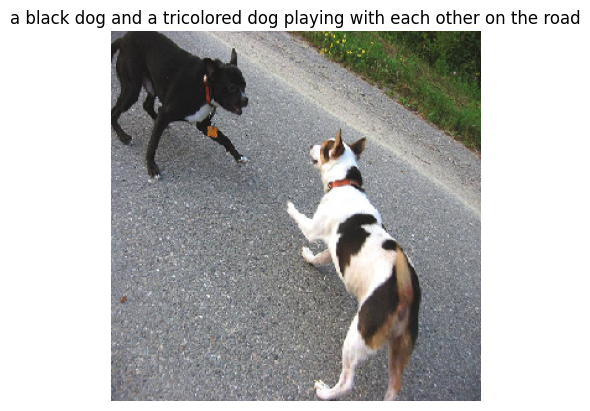

Generated caption: startseq a black dog and a tricolored dog playing with each other on the road


In [117]:
test_img = list(features.keys())[1]
img_path = os.path.join(IMG_DIR, test_img)
caption = generate_caption(model, tokenizer, features[test_img].reshape(1,2048), img_path, max_length)
print("Generated caption:", caption)


In [120]:
import os
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Add

# ------------------------------
# 1. Download Flickr8k dataset
# ------------------------------
DATA_DIR = "/content/flickr8k_data"
IMG_DIR = "/content/flickr8k_data/Flicker8k_Dataset"
CAP_FILE = "/content/flickr8k_data/Flickr8k.token.txt"

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

IMG_URL = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
TXT_URL = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

def download_and_extract(url, extract_to):
    zip_path = os.path.join(DATA_DIR, url.split('/')[-1])
    if not os.path.exists(zip_path):
        print("Downloading", url)
        r = requests.get(url)
        with open(zip_path, 'wb') as f:
            f.write(r.content)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

if not os.path.exists(IMG_DIR):
    download_and_extract(IMG_URL, DATA_DIR)
if not os.path.exists(os.path.join(DATA_DIR, "Flickr8k_text")):
    download_and_extract(TXT_URL, DATA_DIR)


In [127]:

captions_dict = {}
with open(CAP_FILE, 'r') as f:
    for line in f:
        img, caption = line.strip().split('\t')
        img = img.split('#')[0]
        caption = caption.lower().translate(str.maketrans('', '', string.punctuation))
        if img not in captions_dict:
            captions_dict[img] = []
        captions_dict[img].append('startseq ' + caption + ' endseq')

captions_dict = dict(list(captions_dict.items())[:200])
all_captions = [c for caps in captions_dict.values() for c in caps]

# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in all_captions)


inception = InceptionV3(weights='imagenet')
encoder = Model(inception.input, inception.layers[-2].output)

def extract_features(img_path):
    img = load_img(img_path, target_size=(299,299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return encoder.predict(img, verbose=0)

features = {}
for img in captions_dict.keys():
    path = os.path.join(IMG_DIR, img)
    if os.path.exists(path):
        features[img] = extract_features(path)[0]


In [128]:
X1, X2, y = [], [], []

for img, caps in captions_dict.items():
    feat = features[img]
    for cap in caps:
        seq = tokenizer.texts_to_sequences([cap])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]  # right padding
            out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(feat)
            X2.append(in_seq)
            y.append(out_seq)

X1, X2, y = np.array(X1), np.array(X2), np.array(y)

inputs1 = Input(shape=(2048,))
fe1 = Dense(256, activation='relu')(inputs1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = LSTM(256)(se1)

decoder = Add()([fe1, se2])
decoder = Dense(256, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder)

model = Model([inputs1, inputs2], outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_25      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 31, 256)   │    317,696 │ input_layer_26[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 31)        │          0 │ input_layer_26[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 256)       │    524,544 │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 256)       │    525,312 │ embedding_11[0][… │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 256)       │          0 │ dense_30[0][0],   │
│                     │                   │            │ lstm_12[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 256)       │     65,792 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1241)      │    318,937 │ dense_31[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,752,281 (6.68 MB)

 Trainable params: 1,752,281 (6.68 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
model.fit([X1,X2], y, epochs=20, batch_size=32, verbose=2)


Epoch 1/20
375/375 - 4s - 11ms/step - loss: 4.8038
Epoch 2/20
375/375 - 3s - 8ms/step - loss: 3.7939
Epoch 3/20
375/375 - 2s - 7ms/step - loss: 3.2116
Epoch 4/20
375/375 - 2s - 6ms/step - loss: 2.7540
Epoch 5/20
375/375 - 2s - 6ms/step - loss: 2.3361
Epoch 6/20
375/375 - 2s - 6ms/step - loss: 1.9760
Epoch 7/20
375/375 - 3s - 9ms/step - loss: 1.6639
Epoch 8/20
375/375 - 2s - 6ms/step - loss: 1.4114
Epoch 9/20
375/375 - 2s - 6ms/step - loss: 1.1882
Epoch 10/20
375/375 - 2s - 6ms/step - loss: 1.0035
Epoch 11/20
375/375 - 2s - 6ms/step - loss: 0.8496
Epoch 12/20
375/375 - 3s - 9ms/step - loss: 0.7211
Epoch 13/20
375/375 - 2s - 6ms/step - loss: 0.6300
Epoch 14/20
375/375 - 3s - 8ms/step - loss: 0.5536
Epoch 15/20
375/375 - 2s - 6ms/step - loss: 0.4898
Epoch 16/20
375/375 - 3s - 7ms/step - loss: 0.4302
Epoch 17/20
375/375 - 3s - 9ms/step - loss: 0.3992
Epoch 18/20
375/375 - 4s - 11ms/step - loss: 0.3691
Epoch 19/20
375/375 - 2s - 6ms/step - loss: 0.3590
Epoch 20/20
375/375 - 3s - 7ms/step - 

In [130]:
def generate_caption(model, tokenizer, img_path, max_length):

    photo = extract_features(img_path)

    img = load_img(img_path, target_size=(299, 299))
    plt.imshow(img)
    plt.axis('off')


    in_text = 'startseq'
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, padding='post')
        yhat = np.argmax(model.predict([photo, seq], verbose=0))
        word = tokenizer.index_word.get(yhat, None)
        if word is None or word=='endseq':
            break
        in_text += ' ' + word

    plt.title(in_text.replace('startseq ', ''))
    plt.show()
    return in_text


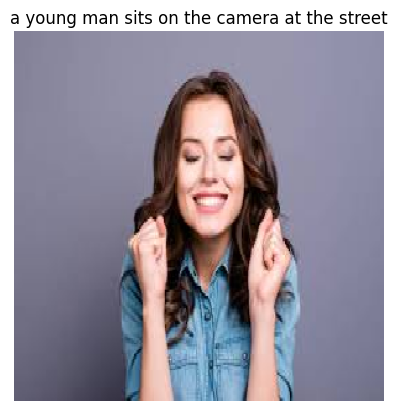

Generated caption: startseq a young man sits on the camera at the street


In [131]:
img_path = "/content/download.jpg"
caption = generate_caption(model, tokenizer, img_path, max_length)
print("Generated caption:", caption)